In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime 
import random
from scipy import stats


from IPython import display

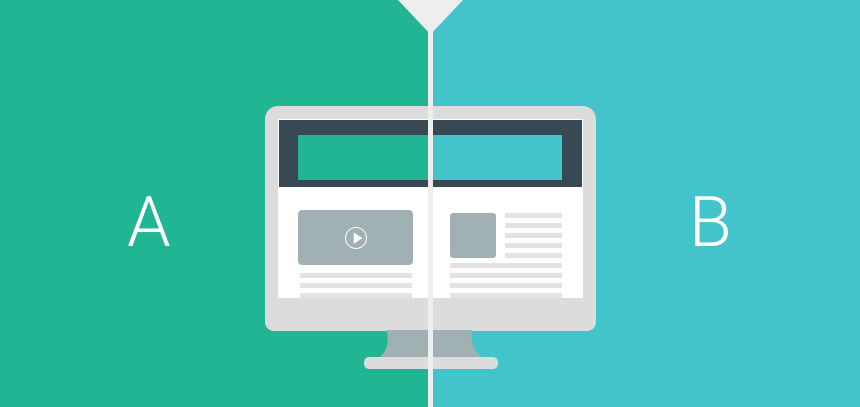

In [2]:
display.Image("AB Test Image.png",width=600, height=600)

**An online e-commerce company has a robust customer service operation. We decided to run a test on our website where we removed 1-800(toll-free) customer service number for half of our website.**

> Define Goal:

>> The impact of removing customer service number from the website.

> Identify Metric:

>> Average Resolution time | First contact Resolution

> Develop Hypothesis:

>> The alternative methods will drive up the customer service concerned metrics.

> Set up the experiemnt:

>> set up the homepage by adding the alternative customer service method. we randomly separate users to treatment and control. The unit of analysis is user. This will ensure that consistent user experience to users. This will ensure that our experiment is trustworthy and independent assumption is not violated.

>> Before the actual experiment conduct, we will run the AA test to ensure the experiment is setup properly.

> Run the Experiment

>> Once the engineer implemented the changes and randomly assigned the users. Let the experiment run for a week. collect the consumer data and prepare the analysis.

> Analyze the result

>> Conduct T-Test and analyze the result. Since the simulated the data. we should be conculde that treatment will increase the conversion rate from home page to product page.

In [3]:
d = ['New Product or Feature Request', 
     'Lack of Follow Up',
     'The Customer Service Rep Was Not Professional', 
     'The Staff Couldn’t Do Much To Help Me',
     'I Was Unable To Talk To A Human',
     'I Keep Getting Transferred/Disconnected',
     'They Didn’t Respond To My Problem On Social Media']

current = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")

AA = pd.DataFrame(columns=['timestamp', 'userid',  'test', 'Queue Time','answer', 'category', 'resolution time'])
AB = pd.DataFrame(columns=['timestamp', 'userid',  'test', 'Queue Time','answer', 'category', 'resolution time'])

In [4]:
p_control = 0.02


for i in range(0, 20000):
    
    timestamp = current -  datetime.timedelta(days = random.randint(a=7, b=14),
                                              hours = random.randrange(12),
                                              minutes = random.randrange(30))
    
    userid = 'userid '+ str(random.randint(1, 500000)) 
    
    item_cat = random.choice(d)
    
    mean_uniform = random.randint(a=30,b=100)
    
    std_uniform = random.randint(a=15, b=30)
    
    queue = round(np.random.normal(mean_uniform, std_uniform),2)
        
    test = 1 if np.random.uniform() > 0.5 else 0

    temp = [timestamp.strftime("%b %d %Y - %H:%M:%S"), userid, test, queue]

    resolute = round(np.random.normal(mean_uniform, std_uniform),2)
    
    if test == 1:
        click = 1 if np.random.uniform() < p_control else 0
        temp.append(click)
        if click == 1:
            temp.append(item_cat)
            temp.append(resolute)
        else: 
            temp.append('NA')
            temp.append(0)

    
    elif test == 0: 
        if timestamp > current - datetime.timedelta(days = 8) and timestamp < current - datetime.timedelta(days = 11):
            click = 1 if np.random.uniform() < p_control+ 0.2 else 0
            temp.append(click)
            if click == 1:
                temp.append(item_cat)
                temp.append(resolute)
            else: 
                temp.append('NA')
                temp.append(0)
            
            
        else:
            click = 1 if np.random.uniform() < p_control else 0
            temp.append(click)
            
            if click == 1:
                temp.append(item_cat)
                temp.append(resolute)
            else: 
                temp.append('NA')
                temp.append(0)

            
        
    AA.loc[len(AA)] = temp

In [5]:
AA['answer'] = pd.to_numeric(AA['answer'])
AA['resolution time'] = pd.to_numeric(AA['resolution time'])


In [6]:
test = AA.loc[AA.test == 1]
control = AA.loc[AA.test == 0]

test_agg = test.groupby('userid') \
       .agg({'answer':'mean'}).reset_index()

control_agg  = control.groupby('userid') \
       .agg({'answer':'mean'}).reset_index()

In [7]:
test_agg.head()

,userid,answer
0,userid 100036,1.0
1,userid 100065,0.0
2,userid 100068,0.0
3,userid 100082,0.0
4,userid 100085,0.0


In [8]:
control_agg.head()

,userid,answer
0,userid 100124,0.0
1,userid 100140,0.0
2,userid 100196,0.0
3,userid 100212,0.0
4,userid 100218,0.0


In [9]:

cal_diff = test_agg['answer'].mean() - control_agg['answer'].mean()
print('The observable difference is',cal_diff, '\n')
t2, p2 = stats.ttest_ind(test_agg['answer'],control_agg['answer'])
print("t = " + str(t2))
print("p = " + str(p2))

The observable difference is 0.00019044031474970552 

t = 0.09420988760467369
p = 0.9249433841508831


In [10]:
AA['Weekday'] = [datetime.datetime.strptime(x, "%b %d %Y - %H:%M:%S").strftime('%A') \
                for x in AA['timestamp']]

temp = AA.groupby(['test', 'Weekday']) \
       .agg({'answer':'mean'}).reset_index()

temp_agg = temp.pivot(index='Weekday', columns='test', values='answer').reset_index()
temp_agg['difference'] = np.absolute(temp_agg[1] -temp_agg[0])
temp_agg

test,Weekday,0,1,difference
0,Friday,0.020850,0.016074,0.004776
1,Monday,0.015504,0.019685,0.004181
2,Saturday,0.019328,0.028414,0.009086
3,Sunday,0.021611,0.021686,0.000075
4,Thursday,0.023847,0.021395,0.002453
5,Tuesday,0.020032,0.019512,0.000520
6,Wednesday,0.021961,0.017802,0.004159


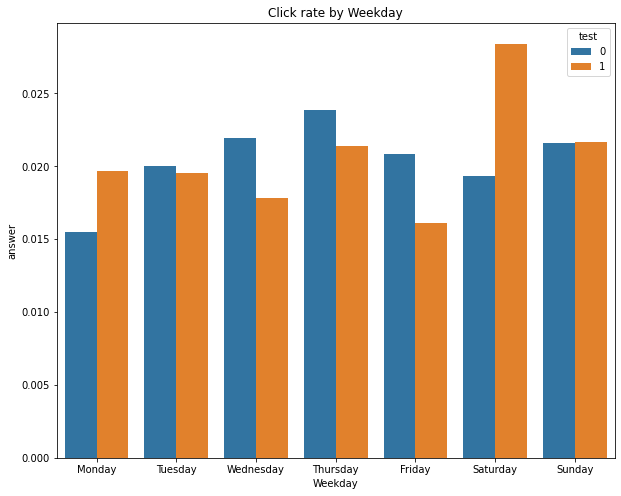

In [11]:
temp['Weekday'] = pd.Categorical(temp['Weekday'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

plt.figure(figsize=(10,8))
plt.title('Click rate by Weekday')
sns.barplot(x="Weekday", y="answer", hue="test", data=temp)
plt.show()

In [12]:
y = temp_agg['Weekday'][np.argmax(temp_agg['difference'])]

temp = AA.loc[[x in [y] for x in AA.Weekday]]

test = temp.loc[temp.test == 1]
control = temp.loc[temp.test == 0]

test_agg = test.groupby('userid') \
       .agg({'answer':'mean'}).reset_index()

control_agg  = control.groupby('userid') \
       .agg({'answer':'mean'}).reset_index()

In [13]:

cal_diff = test_agg['answer'].mean() - control_agg['answer'].mean()
print('The observable difference is',cal_diff, '\n')
t2, p2 = stats.ttest_ind(test_agg['answer'],control_agg['answer'])
print("t = " + str(t2))
print("p = " + str(p2))

The observable difference is 0.009108287864908995 

t = 1.4733174362040564
p = 0.1407937122908218


In the AA test, it is clear that the difference is not statistically significant. However, it we look at Saturday performance, it is obvious that the concerned metric shows abnormal. we should further investigate. Is there an error or not?

In [14]:
p_control = 0.02
p_test = 0.04


for i in range(0, 20000):
    
    timestamp = current -  datetime.timedelta(days = random.randrange(7),
                                              hours = random.randrange(12),
                                              minutes = random.randrange(30))
    
    userid = 'userid '+ str(random.randint(1, 500000)) 
    
    item_cat = random.choice(d)
    
    mean_uniform = random.randint(a=30,b=100)
    
    std_uniform = random.randint(a=15, b=30)
    
    queue = round(np.random.normal(mean_uniform, std_uniform),2)
        
    test = 1 if np.random.uniform() > 0.5 else 0

    temp = [timestamp.strftime("%b %d %Y - %H:%M:%S"), userid, test, queue]

    resolute = round(np.random.normal(mean_uniform, std_uniform),2)
    
    if test == 1:
        click = 1 if np.random.uniform() < p_control else 0
        temp.append(click)
        if click == 1:
            temp.append(item_cat)
            temp.append(resolute)
        else: 
            temp.append('NA')
            temp.append(0)

    
    elif test == 0: 
        click = 1 if np.random.uniform() < p_test else 0
        temp.append(click)
        if click == 1:
            temp.append(item_cat)
            temp.append(resolute)
        else: 
            temp.append('NA')
            temp.append(0)
            
        
    AB.loc[len(AB)] = temp
    
AB['answer'] = pd.to_numeric(AB['answer'])
AB['resolution time'] = pd.to_numeric(AB['resolution time'])

In [15]:
test = AB.loc[AB.test == 1]
control = AB.loc[AB.test == 0]

test_agg = test.groupby('userid') \
       .agg({'answer':'mean'}).reset_index()

control_agg  = control.groupby('userid') \
       .agg({'answer':'mean'}).reset_index()

In [16]:

cal_diff = test_agg['answer'].mean() - control_agg['answer'].mean()
print('The observable difference is',cal_diff, '\n')
t2, p2 = stats.ttest_ind(test_agg['answer'],control_agg['answer'])
print("t = " + str(t2))
print("p = " + str(p2))

The observable difference is -0.017515230701881556 

t = -7.372141243711907
p = 1.7451255954878396e-13


In [17]:
AB['Weekday'] = [datetime.datetime.strptime(x, "%b %d %Y - %H:%M:%S").strftime('%A') \
                for x in AB['timestamp']]

temp = AB.groupby(['test', 'Weekday']) \
       .agg({'answer':'mean'}).reset_index()

temp_agg = temp.pivot(index='Weekday', columns='test', values='answer').reset_index()
temp_agg['difference'] = np.absolute(temp_agg[1] -temp_agg[0])
temp_agg

test,Weekday,0,1,difference
0,Friday,0.035486,0.023464,0.012022
1,Monday,0.034290,0.022378,0.011912
2,Saturday,0.050283,0.018144,0.032140
3,Sunday,0.036610,0.018789,0.017821
4,Thursday,0.036491,0.020129,0.016362
5,Tuesday,0.032145,0.018659,0.013486
6,Wednesday,0.038040,0.019795,0.018244


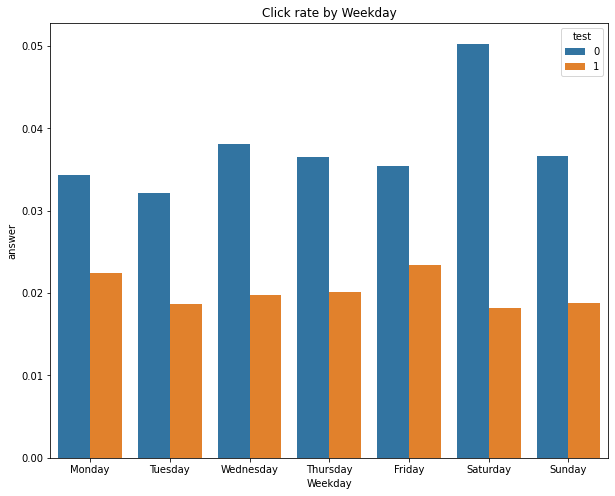

In [19]:
temp['Weekday'] = pd.Categorical(temp['Weekday'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

plt.figure(figsize=(10,8))
plt.title('Click rate by Weekday')
sns.barplot(x="Weekday", y="answer", hue="test", data=temp)
plt.show()

Now, we correct the mistake that we found at AA test. Correctly implemented the change and make sure the engineering team all collaborate together to make sure the change is implemented correctly. 

We can conclude that the new version is better. 